# Causal probabilistic programming without tears (part I)

Despite the tremendous progress over the last several decades in reducing causal inference to statistical practice, the \"causal revolution\" proclaimed by Judea Pearl and others remains incomplete, with a sprawling and fragmented literature inaccessible to non-experts and still somewhat isolated from cutting-edge machine learning research and software tools.

Probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models. 

In this tutorial, we elaborate on this idea with three key observations inspiring ChiRho's design and outline a causal Bayesian workflow for using ChiRho to answer causal questions.

## Outline
- [Introduction](#causal-probabilistic-programming-without-tears)
- [Outline](#outline)
- [Observation 1: Causal Models are Probabilistic Programs](#observation-1:-causal-models-are-probabilistic-programs)
    - [Defining a Causal Model](#defining-a-causal-model)
    - [Simulating Observational Data](#simulating-observational-data-with-fixed-parameters)
    - [Applying an Intervention](#applying-an-intervention)
    - [Simulating Interventional Data](#simulating-interventional-data-with-fixed-parameters)
    - [Transforming Causal Models using ChiRho](#transforming-causal-models-using-ChiRho---do)
- [References](#references)

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a probability distribution over a set of variables, but programs often contain more information than just the joint distributions they induce. In practice, when we write probabilistic programs in languages such as Pyro we often bring to bear knowledge of causal relationships between variables, and implicitly, how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability distributions, indexed by a set of *interventions*. This set always includes a trivial *identity intervention*, which maps to the usual (acausal) joint distribution over random variables induced by simply executing the program. However, for other interventions the resulting joint distributions can differ significantly, as we'll see later throughout this tutorial.

Somewhat less formally, causal models using these (nontrivial) interventions are useful when we want to represent hypothetical changes to a domain, such as a policy that encourages people to stop smoking. To ground this out a bit more concretely, consider the following Pyro program describing a causal model relating three random variables, *stress*, *smokes*, and *cancer*.

**Note:** Later we'll see how to think of interventions as program transformations. ChiRho defaults to the trivial *identity intervention* if none are applied explicitly. The result of applying this identity intervention to a causal model is sometimes called an *observational model* or *factual model*.

### Defining a Causal Model

In [1]:
import pyro
from pyro.distributions import Bernoulli

def causal_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()
    # For now we only return smokes because we need to return a single value for the predictive handler.
    # We need to return smokes because the trace address for `smokes` does not include the interventions.
    # TODO: address this in the future.
    return smokes
    # return stress, smokes, cancer

Our `causal_model` takes as input three sets of parameters, here just marginal and conditional probability tables, and returns a sample from the joint distribution over a single individual's *stress*, *smokes*, and *cancer* attributes. For now, let's just choose some parameters by hand, but later we'll see how we can place priors over these parameters to express broader uncertainty and enable Bayesian causal inference. 

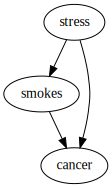

In [2]:
import torch

stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(causal_model, (stress_pt, smokes_cpt, cancer_cpt))

### Simulating Observational Data with Fixed Parameters

Fortunately, all causal models written in ChiRho compose freely with the probabilistic programming tooling in Pyro. Without belaboring the details, Pyro provides support for probabilistic modeling and inference with a set of composable *effect handlers*, which can be thought of as context managers that provide nonstandard interpretation of `pyro.sample` statements in Pyro programs. For more background on Pyro and its use of effect handlers, see https://pyro.ai/examples/intro_long.html and https://pyro.ai/examples/effect_handlers.html. Perhaps not surprisingly, ChiRho's main capabilities also make heavy use of similar effect handlers.

As an example, let's use Pyro's `plate` effect handler to repeatedly sample from the `causal_model` to approximate the joint distribution for all of the attributes. 

In [3]:
def population_causal_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt):
    with pyro.plate("individuals", n_individuals, dim=-1):
        return causal_model(stress_pt, smokes_cpt, cancer_cpt)

n_individuals = 10000

smokes_obs = population_causal_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt)
# stress_obs, smokes_obs, cancer_obs = population_causal_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt)

print(smokes_obs.shape)
# print(stress_obs.shape, smokes_obs.shape, cancer_obs.shape)

torch.Size([10000])


Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke and how likely they are to get cancer. To understand this relationship a bit better, we can simulate observations from our model.

[Text(0.5, 1.0, 'Observational Data - Fixed Parameters')]

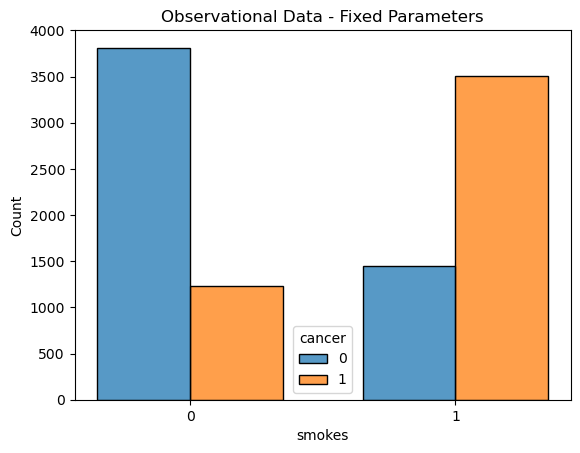

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_proportions_single(prediction, title):
    # TODO: Make this prettier
    cancer = prediction['cancer'][0]
    smokes = prediction['_RETURN'][0]

    data = torch.concat((smokes.reshape(-1, 1), 
                         cancer.reshape(-1, 1)), axis=-1)
    frame = pd.DataFrame(data.numpy(),
                          columns=["smokes", "cancer"]).astype(
            "category").replace({0:"0", 1:"1"})
    
    return sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame).set(title=title)

predictive_fixed = pyro.infer.Predictive(population_causal_model, num_samples=1000, return_sites=("cancer", "_RETURN"))
prediction_fixed = predictive_fixed(n_individuals, stress_pt, smokes_cpt, cancer_cpt)

visualize_proportions_single(prediction_fixed, "Observational Data - Fixed Parameters")

As we can see clearly from this simulation, individuals who smoke are much more likely to get cancer than individuals who don't. Of the ~5,000 simulated individuals who smoke ~3600 got cancer, roughly 72% of the smokers. Of the remaining ~5,000 simulated individuals who did not smoke only ~1,200 individuals got cancer, a much lower 24% of the smoking population.

We can also approximate our uncertainty in this conclusion by repeating the process a number of times, each time calculating the proportions of individuals with cancer for smokers and non-smokers.

<Axes: title={'center': 'Observational Data - Fixed Parameters'}, xlabel='Proportion of Individuals w/ Cancer', ylabel='Density'>

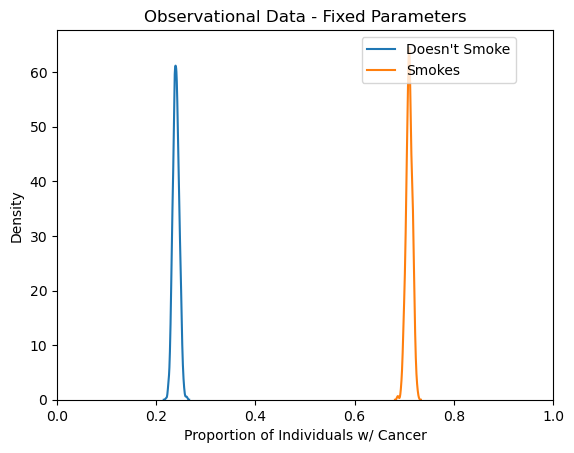

In [5]:
def visualize_proportions_multiple(prediction, title, position = (0.6, 1)):
    # TODO: make these violin plots with individual data points.
    cancer = prediction['cancer']
    smokes = prediction['_RETURN']

    cancer_and_smokes = cancer * smokes
    cancer_given_smokes = cancer_and_smokes.sum(1) / smokes.sum(1)
    cancer_and_not_smokes = cancer * (1 - smokes)
    cancer_given_not_smokes = cancer_and_not_smokes.sum(1) / (1 - smokes).sum(1)
    # TODO: make the smoothing kernel sharper.
    ax = sns.kdeplot(data=cancer_given_not_smokes.detach().numpy(), label="Doesn't Smoke", legend=True)
    sns.kdeplot(data=cancer_given_smokes.detach().numpy(), label="Smokes", ax=ax, legend=True)
    ax.legend(loc='upper left', bbox_to_anchor=position)
    ax.set(xlabel='Proportion of Individuals w/ Cancer', ylabel='Density', title=title, xlim=(0, 1))
    return ax

visualize_proportions_multiple(prediction_fixed, "Observational Data - Fixed Parameters")

As we can see clearly, even when simulating many times our model tells us that individuals who smoke are consistently much more likely to get cancer than individuals who don't. In fact, since our model together with the chosen probability tables describe a unique joint distribution over individual attributes, we're only approximating an answer that we could've straightforwardly obtained by hand. Let  $c, s, t$ stand for the presence of cancer, smoking and stress, respectively. $P(t \vert s) = \frac{P(s\vert t)P(t)}{P(s)}= .8$, and $P(t\vert \neg s ) = \frac{P(\neg s \vert t)P(t)}{P(\neg s)} = .2$. Then, $P(c\vert s) = P(c\vert t, s ) \times P(t \vert  s) + P(c\vert t, s) \times P(\neg t\vert s) =.71$, and analogously $P(c\vert \neg s) = .24$, which are modes of the empirical distributions shown above. The variance here is only due to the fact that we are simulating a finite population.

So far we have a program that describes the distribution over data given model parameters. Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space" induces a joint distribution over data.

![fig1](figures/Conditional_Distribution_of_Data.png)

### Applying an Intervention

Simulating from our `causal_model` is certainly interesting and informative, but it doesn't exactly tell us what we're interested in. We want to know to what extent smoking *causes* cancer, not just whether smoking is associated with cancer. To answer this question, we can instead sample from a modified version of our model in which individuals are forced to smoke or not smoke, regardless of their level of stress. We can represent these kinds of modifications as **interventions**, and implement them in ChiRho as a special kind of program transformation. Later we'll see how ChiRho helps to automate the application of these kinds of interventions, but to build some intuition let's first walk through what these new programs would look like if we built them by hand instead.

Consider the following new Pyro program; `forced_smokes_model`, which closely resembles our original `causal_model` except in how the *smokes* attribute is assigned. Specifically, we've replaced the expression `smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()` with the expressions `smokes = pyro.deterministic("smokes", smokes_assignment)`, where `smokes_assignment` is now an argument.

In [6]:
def forced_smokes_model(stress_pt, smokes_cpt, cancer_cpt, smokes_assignment):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", smokes_assignment)
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()
    # For now we only return smokes because we need to return a single value for the predictive handler.
    # We need to return smokes because the trace address for `smokes` does not include the interventions.
    # TODO: address this in the future.
    return smokes
    # return stress, smokes, cancer

def population_forced_smokes_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt):
    # Let's imagine that we force half the people to always smoke and half to never smoke.
    smokes_assignment = torch.tensor([0, 1]).repeat(n_individuals // 2)
    with pyro.plate("individuals", n_individuals, dim=-1):
        return forced_smokes_model(stress_pt, smokes_cpt, cancer_cpt, smokes_assignment)

### Simulating Interventional Data with Fixed Parameters

Let's visualize a simulation from these new programs (compare this to the previous visualization based on the original simulation). First, one run on a barplot, then the proportions obtained in multiple (1k) runs using a kernel density estimate.

[Text(0.5, 1.0, 'Intervened Data - Fixed Parameters')]

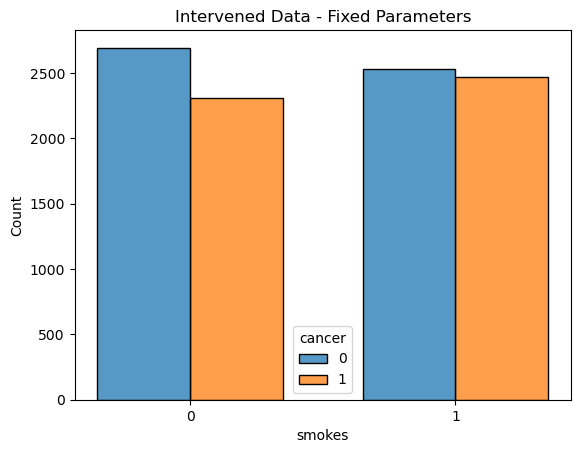

In [7]:
predictive_int_fixed = pyro.infer.Predictive(population_forced_smokes_model, num_samples=1000, return_sites=("cancer", "_RETURN"))
prediction_int_fixed = predictive_int_fixed(n_individuals, stress_pt, smokes_cpt, cancer_cpt)

visualize_proportions_single(prediction_int_fixed, "Intervened Data - Fixed Parameters")

<Axes: title={'center': 'Interventional Data - Fixed Parameters'}, xlabel='Proportion of Individuals w/ Cancer', ylabel='Density'>

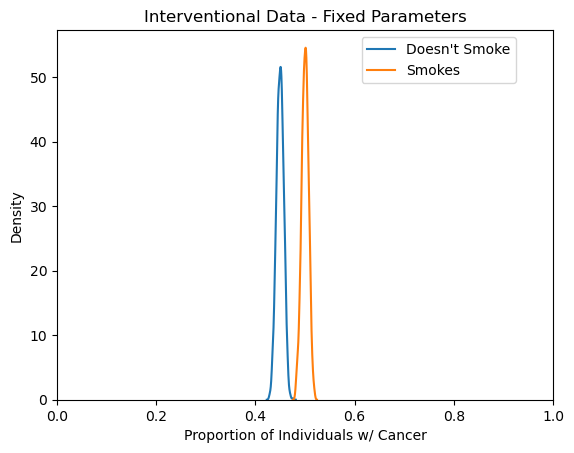

In [8]:
visualize_proportions_multiple(prediction_int_fixed, "Interventional Data - Fixed Parameters")

Using our intervened model we can clearly see that changing the mechanism by which individuals choose whether or not to smoke dramatically changes the joint distribution between smoking and cancer. In our observational model, individuals who smoke are much more likely to get cancer than those who don't smoke. However, in our modified model in which individuals are either forced to smoke or forced not no smoke, the dependence between smoking and cancer nearly disapears.

The phenomenon we're observing in this (contrived) example is known as confounding. Here, the reason we see a statistical dependency between smoking and cancer in our original `causal_model` without any interventions is because of the individuals' stress. Given the parameters we happened to choose, individuals who are stressed are more likely to smoke and stress causes an increase in cancer. The confounding effect of stress dissapears in our intervened program, as stress no longer influences whether individuals smoke or not.

In causal inference settings we often wish to answer a specific scientific or policy question using our causal models. For example, we may be interested in the **Average Treatment Effect** (ATE), the average difference in the proportion of individuals with cancer between individuals who were forced to smoke and those who were forced to not smoke. This ATE quantity can be expressed as a function of the population of individuals' attributes after applying an intervention.

<Axes: title={'center': 'Interventional Data - Fixed Parameters'}, xlabel='Average Treatment Effect (ATE)', ylabel='Density'>

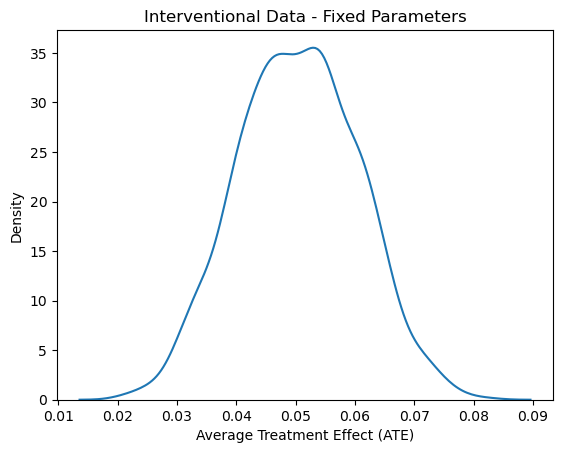

In [9]:
def visualize_ATE(prediction, title, position=(0.6, 1)):
    
    cancer = prediction['cancer']
    smokes = prediction['_RETURN']

    cancer_and_smokes = cancer * smokes
    cancer_given_smokes = cancer_and_smokes.sum(1) / smokes.sum(1)
    cancer_and_not_smokes = cancer * (1 - smokes)
    cancer_given_not_smokes = cancer_and_not_smokes.sum(1) / (1 - smokes).sum(1)

    ate = cancer_given_smokes - cancer_given_not_smokes

    ax = sns.kdeplot(data=ate.detach().numpy())
    ax.set(xlabel='Average Treatment Effect (ATE)', ylabel='Density', title=title)
    return ax

visualize_ATE(prediction_int_fixed, "Interventional Data - Fixed Parameters")

**Note:** Just as in the observational setting above, the expectation of the proportion of individuals with cancer in this interventional setting also has a closed-form analytic solution that we can easily compute by hand. This is the case here because (i) the structure of our `causal_model` is isomorphic to a causal graphical model, and thus Pearl's backdoor adjustment formula applies, and (ii) all attributes ($stress$, $smokes$, $cancer$) are discrete. In more complicated examples this will not be the case. Using Pearl's $do$ notation (see Pearl, 2009), we have $P(c\vert do(s)) = P(c\vert s, t)P(t) + P(c\vert s, \neg t) P(\neg t) = 0.5$, and anologously $P(c\vert do(\neg s)) = .45$. Therefore, we have that $ATE \equiv E[P(c\vert do(s))] - E[P(c\vert do(\neq s))] = 0.5 - 0.45 = 0.05$, which is again consistent with our answer above.

### Transforming Causal Models using ChiRho - `do`


So far, we've accomplished some limited form of causal reasoning by manually rewriting our original program, replacing the mechanism for how individuals choose to smoke directly in Pyro's syntax, and then simulating from the new programs. In fact, even though we called our program a `causal_model`, we haven't seen anything that we couldn't already do in an ordinary probabilistic programming language. 

This manual approach is perfectly reasonable in simple scenarios where we have a single model and a single "thought experiment" we want to explore. However, as we'll see throughout these tutorials and examples, reasoning about cause and effect can often involve much more complicated compositions of program transformations. For example, in our [Mediation Analysis](mediation.ipynb) example we'll need to simulate multiple counterfactual models simultaneously, with intervention assignments in one model that depend on simulated outcomes in another. 

One of the key insights behind ChiRho (and borrowed from Pearl's structural formalism \[Pearl 2009\]) is that an intervention can be represented as model agnostic program transformation, that is, a function $I: \mathcal{P} \rightarrow \mathcal{P}$, where $\mathcal{P}$ is the space of programs in our language. In ChiRho, and in many formalisms for causal models, we'll assume that models satisfy a kind of locality-preserving property known as autonomy \[Aldrich 1989\]. This autonomy property implies that interventions can be accurately represented as an alteration of a small number of model components, and all other model components (and the causal relationships among them) remain unchanged.

In that vein, ChiRho addresses the complexity of causal reasoning by automating a number of probabilistic program transformations; including interventions, construction of parallel counterfactual worlds, and (as we'll see in subsequent tutorials) automatic reparameterization for counterfactual or "what if" reasoning. 

For example, instead of rewriting the code by hand, we can implement our `forced_smokes_model` succinctly as follows using ChiRho's `do` program transformation. As the name implies, this special function `do` operates very similarly to the $do$ operator used with structural causal models and causal graphical models. Here, `do` takes as input a probabilistic program and a dictionary describing the intervention assignment and returns a transformed probabilistic program with the intervention applied.

In [10]:
from chirho.interventional.handlers import do

def forced_smokes_model(stress_pt, smokes_cpt, cancer_cpt, smokes_assignment):
    transformed_model = do(causal_model, {"smokes": smokes_assignment})
    return transformed_model(stress_pt, smokes_cpt, cancer_cpt)

Just as with our manual implementation of the `forced_smokes_model`, models constructed using ChiRho's `do` transformation are probabilistic programs in Pyro, and can thus freely compose with all of Pyro's effect handlers. For example, we can again use an `plate` effect handler to sample from a population of individuals by calling our `forced_smokes_model` in the context of a Pyro `plate`.

In [11]:
def population_forced_smokes_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt):
    # Let's imagine that we force half the people to always smoke and half to never smoke.
    smokes_assignment = torch.tensor([0, 1]).repeat(n_individuals // 2)
    with pyro.plate("individuals", n_individuals, dim=-1):
        return forced_smokes_model(stress_pt, smokes_cpt, cancer_cpt, smokes_assignment)

population_forced_smokes_model(n_individuals, stress_pt, smokes_cpt, cancer_cpt)

tensor([0, 1, 0,  ..., 1, 0, 1])

To recap, so far we've constructed a causal model describing how data is generated in the actual world we can observe, which we called `causal_model`, and transformed our causal model to represent our thought experiments, or interventions, resulting in the `forced_smokes_model` program. Then, we sampled from our original and transformed models to generate simulated outcomes, and finally summarized the simulated outcomes yielding an answer to our causal query. Again, this process can be viewed somewhat abstractly as follows:

![fig2](figures/Interventional_Conditional.png)

In this section, we've seen that a probabilistic program specifies a causal model by:
  1. specifying a "default" or "observational" joint distribution over the variables of interest according to the usual semantics of probabilistic programming languages, and
  2. encoding the information  necessary for determining the new joint distribution under an arbitrary intervention (program transformation)---to apply the transformation and derive the new joint distribution.

## References

Pearl, Judea. Causality: Models, Reasoning and Inference. 2nd ed. USA: Cambridge University Press, 2009.

Aldrich, John. “Autonomy.” Oxford Economic Papers 41, no. 1 (1989): 15–34.

Petersen, Maya L., and Mark J. van der Laan. "Causal models and learning from data: integrating causal modeling and statistical estimation." Epidemiology (Cambridge, Mass.) 25.3 (2014): 418.